In [2]:
import numpy as np
import pandas as pd
import os
import random

import warnings
warnings.filterwarnings('ignore')

import prophet
from prophet.diagnostics import cross_validation, performance_metrics

import matplotlib.pyplot as plt

import statsmodels.api as sm

train = pd.read_csv("./data/train.csv")




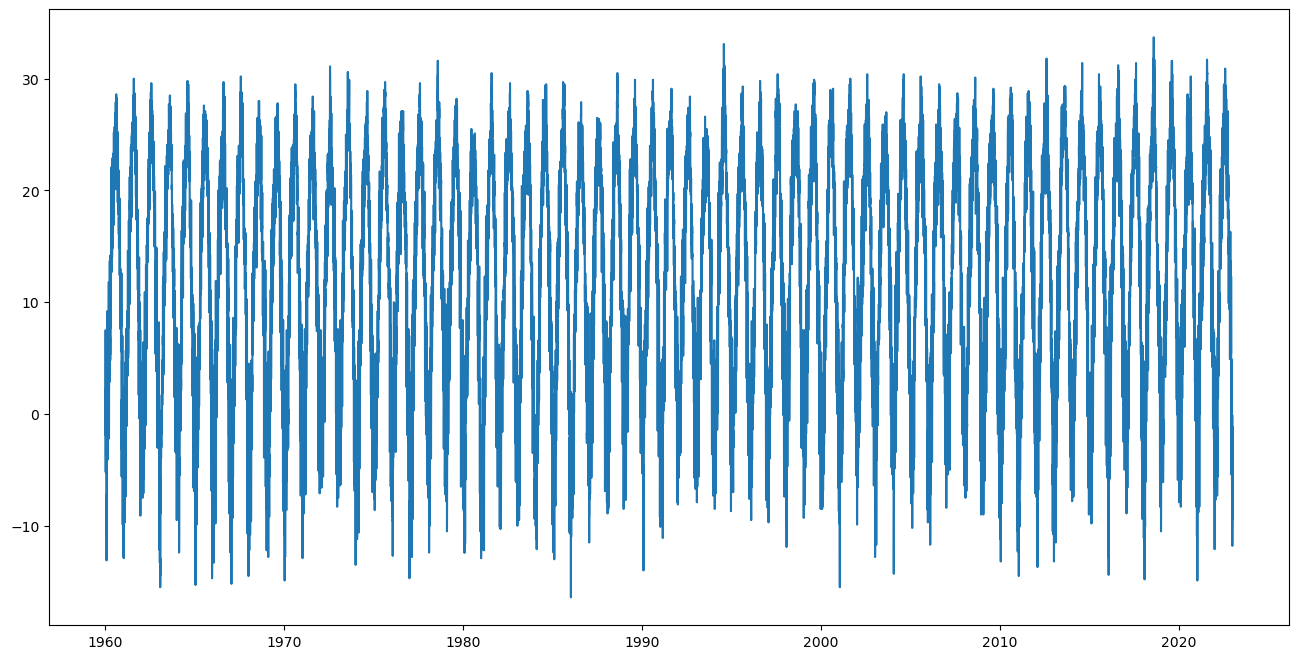

In [3]:
train['일시'] = pd.to_datetime(train['일시'])
plt.figure(figsize=(16,8))

plt.plot(train['일시'], train['평균기온'])
plt.show()

In [4]:
df_train = train[['일시','평균기온']]
df_train.rename(columns={'일시': 'ds', '평균기온': 'y'}, inplace=True)

In [5]:
import itertools

param_grid = {
    'growth': ['linear'],
    'changepoint_prior_scale' : [0.01, 0.03, 0.8],
    'changepoint_range' : [0.8, 0.9, 0.95],
    'seasonality_prior_scale': [12.0, 15.0],
    'seasonality_mode': ['additive'],
    'yearly_seasonality' : [15]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []

# initial: 학습할 구간, horizon: 예측할 구간, period: cutoff 간격
# 3년 주기로 15년치를 학습하고 이후 1년을 예측
for params in all_params:
    m = prophet.Prophet(**params).add_seasonality(name='season', period=90, fourier_order=5).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, initial='5475 days', period='1095 days',horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

03:48:46 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:49 - cmdstanpy - INFO - Chain [1] start processing
03:48:49 - cmdstanpy - INFO - Chai

KeyboardInterrupt: 

In [6]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'growth': 'linear', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': 15}


In [14]:
m = prophet.Prophet(growth = 'linear',
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=10,
    yearly_seasonality=15,
    seasonality_mode='additive').add_seasonality(name='season', period=90, fourier_order=5)
m.fit(df_train)
future = m.make_future_dataframe(periods=358, freq='d') 
forecast = m.predict(future)

08:39:55 - cmdstanpy - INFO - Chain [1] start processing
08:39:59 - cmdstanpy - INFO - Chain [1] done processing


,일시,평균기온
0,2023-01-01,-1.0
1,2023-01-02,-1.1
2,2023-01-03,-1.2
3,2023-01-04,-1.2
4,2023-01-05,-1.3
...,...,...
353,2023-12-20,0.6
354,2023-12-21,0.5
355,2023-12-22,0.4
356,2023-12-23,0.3


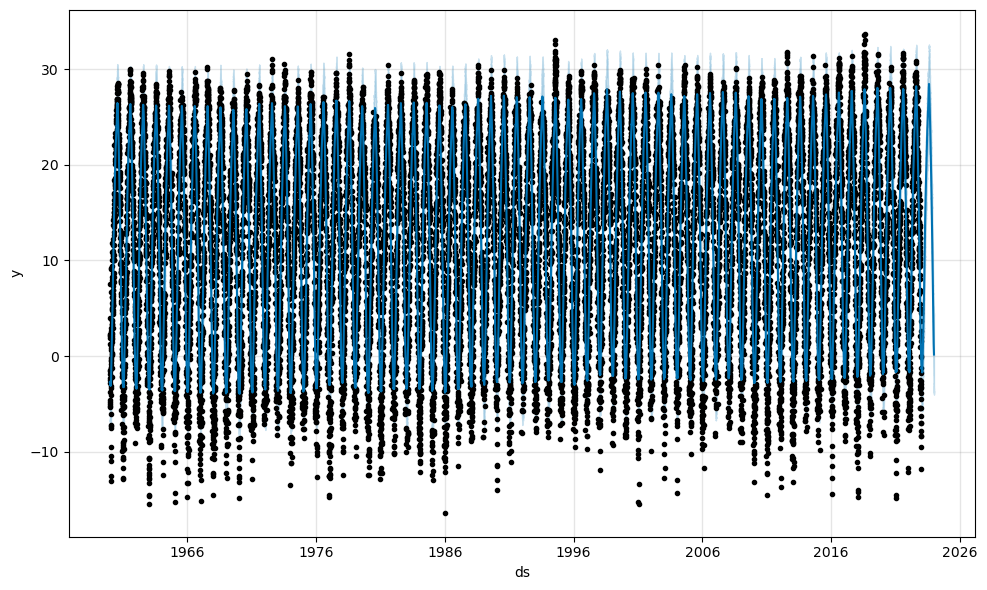

In [15]:
m.plot(forecast)
predict = list(forecast[forecast['ds'].apply(lambda x: x.year) == 2023]['yhat'])
submission = pd.read_csv("./data/sample_submission.csv")
submission['평균기온'] = np.round(predict, 1)
submission

In [16]:
submission.to_csv('./test_1.csv', index=False)